# Text based
- add label to text
- set anchor text
- cosine similarity
- cross validation/AUC

In [2]:
import geopandas as gpd
import numpy as np
import pandas as pd
from shapely.geometry import Polygon
from shapely.geometry import Point
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

## Gentrified Texts

During this part we aimed to creat a dataframe containing all the information we need for the analysis. So we need to conbine all the data together.

We have:
1. lsoa data(with gentrified label)
2. structural data(population etc.)
3. text data(with coorinate)

In [3]:
# merge the gentri label to the vectorization text
# use 'polygon' or 'wgs84_polygon', depend on what coordinate the label is
# load gentri label
lsoa_label = gpd.read_file("data/gentri_data/london_gentri_labeled_25_only.shp")
lsoa_label.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

## joined the structual data as well

In [5]:
stru_data = pd.read_csv("data/all_stru_data_added.csv")

In [6]:
print(lsoa_label.columns)
print(stru_data.columns)

Index(['LSOA code', 'LSOA11NM', 'imd_score_', 'price_grow', '2019_final',
       '25_price_g', '25_imd_imp', 'gentrified', 'geometry'],
      dtype='object')
Index(['LSOA Code', 'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
       'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
       'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
       'sale_avg', 'single_per', 'less_10km_per'],
      dtype='object')


In [7]:
stru_data = stru_data.rename(columns={'LSOA Code': 'LSOA code'})
lsoa_label = lsoa_label.merge(stru_data, on= "LSOA code", how="left")

In [8]:
# use the wgs84_polygon to join the label with text
# read the text
text = pd.read_parquet("sbert_encoded_data.parquet")
print(text.columns)

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'sbert_374', 'sbert_375', 'sbert_376', 'sbert_377', 'sbert_378',
       'sbert_379', 'sbert_380', 'sbert_381', 'sbert_382', 'sbert_383'],
      dtype='object', length=401)


In [9]:
# turn polygon coordinate into shapely 
# make sure to drop the null geodata
text_valid = text[text['wgs84_polygon.coordinates'].notnull()].copy()
text_valid["geometry"] = text_valid["wgs84_polygon.coordinates"].apply(lambda coords: Polygon(coords[0]))
# creat GeoDataFrame， set WGS84 coordinate
gdf_text = gpd.GeoDataFrame(text_valid, geometry="geometry", crs="EPSG:4326")

In [10]:
# set to 27700
gdf_27700 = gdf_text.to_crs("EPSG:27700")

In [29]:
joined = gpd.sjoin(gdf_27700, lsoa_label[["LSOA code", "geometry", "gentrified", 
                                           'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
                                            'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
                                            'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
                                            'sale_avg', 'single_per', 'less_10km_per']], 
                                          how="left", predicate="within")

In [30]:
print("the percentage of texts being labeled:", joined['gentrified'].notna().mean())

the percentage of texts being labeled: 0.8842856683494646


In [31]:
# check the texts
print("total texts:", len(gdf_27700))
print("text within lsoa:", joined['gentrified'].notna().sum())

total texts: 155495
text within lsoa: 137502


Geometry seems fine, and not all texts are within lsoas, meaning some text polygon cross over more than one lsoas.

Solutions: use the centroid geometry for label

In [32]:
# get the centroid of each polygon
gdf_27700["centroid"] = gdf_27700.geometry.centroid

In [37]:
# spatial join
joined_centroid = gpd.sjoin(gdf_27700.set_geometry("centroid"), lsoa_label[["geometry", "gentrified", 
                                                                            'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
                                                                            'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
                                                                            'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
                                                                            'sale_avg', 'single_per', 'less_10km_per']],
                                                                            how="left",predicate="within")

In [38]:
# check the texts again
print("total texts:", len(gdf_27700))
print("text within lsoa:", joined_centroid['gentrified'].notna().sum())

total texts: 155495
text within lsoa: 155367


There's still 128 left, meaning it might happened to be on the boundary of lsoas.

Remove

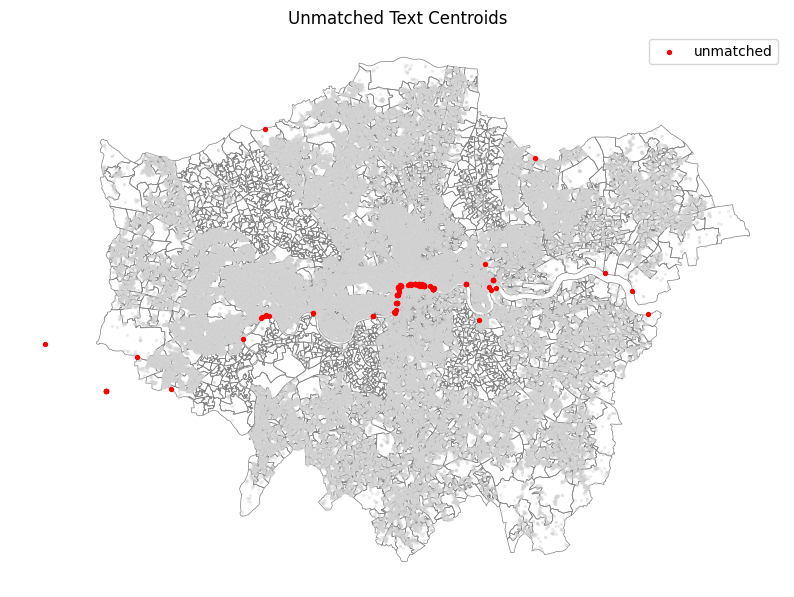

In [19]:
import matplotlib.pyplot as plt

# map the unlabelled points
unmatched = joined_centroid[joined_centroid["gentrified"].isna()]
fig, ax = plt.subplots(figsize=(10, 10))
lsoa_label.plot(ax=ax, facecolor="none", edgecolor="gray", linewidth=0.5)
gdf_27700.set_geometry("centroid").plot(ax=ax, color="lightgray", markersize=2, alpha=0.3)
unmatched.set_geometry("centroid").plot(ax=ax, color="red", markersize=8, label="unmatched")


plt.legend()
plt.title("Unmatched Text Centroids")
plt.axis("off")
plt.show()


In [39]:
joined_cleaned = joined_centroid[joined_centroid["gentrified"].notna()].copy()

In [40]:
joined_cleaned.columns

Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'shared_per', 'converted_per', 'level_4_pop', 'level_4_per',
       'prof_occ_count', 'prof_occ_per', 'pro_sale_2019', 'sale_avg',
       'single_per', 'less_10km_per'],
      dtype='object', length=420)

The model has some predicting capabilities (with an AUC value slightly over 0.6), but its ability to predict gentrified = 1 is still insufficient.

## Anchor texts

1. set anchor text, using sbert to encode them

2. perform similarity calculation for each text


In [104]:
# anchor and encode
# add another typr here: transport/infrusturcture
anchor_dict = {
    "residential": ["flat conversion", "refurbishment", "luxury dwelling"],
    "commercial": ["coffee shop", "gallery", "retail unit upgrade"],
    "green": ["park improvement", "landscaping", "tree planting"],
    "cultural": ["artist studios", "cultural space", "gallery conversion"],
    "infrustructure": ["station", "lighting enhancement", "utilities upgrade"] 
}
sbert_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

anchor_vecs = {
    k: np.mean(sbert_model.encode(v), axis=0) for k, v in anchor_dict.items()
}

this step might take a few hours

In [105]:
# def iterate_anchor_update(sentences, anchor_vecs, sbert_model, topk=20, max_iter=10, tol=1e-4):
    
#     prev_anchor_vecs = {k: v.copy() for k, v in anchor_vecs.items()}
#     all_sentences = [sent for sent_list in sentences for sent in sent_list]
#     all_sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

#     for iteration in range(max_iter):
#         print(f"\n🔁 Iteration {iteration + 1}")
#         updated_vecs = {}
#         total_shift = 0.0
        
#         for cat in tqdm(anchor_vecs, desc="Updating anchors"):
#             sims = cosine_similarity([anchor_vecs[cat]], all_sent_vecs)[0]
#             top_idx = np.argsort(sims)[-topk:][::-1]
#             top_sent_vecs = all_sent_vecs[top_idx]
#             new_vec = np.mean(top_sent_vecs, axis=0)
            
#             shift = np.linalg.norm(new_vec - anchor_vecs[cat])
#             total_shift += shift
#             updated_vecs[cat] = new_vec
        
#         print(f"🔍 Mean anchor shift: {total_shift / len(anchor_vecs):.6f}")
        
#         # Check convergence
#         if total_shift / len(anchor_vecs) < tol:
#             print("✅ Converged.")
#             break
        
#         anchor_vecs = updated_vecs

#     return anchor_vecs

In [106]:
# updated_anchor_vecs = iterate_anchor_update(
#     sentences=joined_cleaned['sentences'],
#     anchor_vecs=anchor_vecs,
#     sbert_model=sbert_model,
#     topk=20,
#     max_iter=10,
#     tol=1e-4
# )

In [107]:
# def extract_topk_sentences_per_anchor(anchor_vecs, all_sentences, sbert_model, topk=10):
#     """
#     返回每个 anchor 类别对应的 top-k 最相关句子
#     """
#     print(f"\n Extracting top-{topk} sentences per anchor...")

#     sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

#     anchor_top_sentences = {}

#     for cat, anchor_vec in anchor_vecs.items():
#         sims = cosine_similarity([anchor_vec], sent_vecs)[0]
#         sorted_idx = np.argsort(sims)[::-1]  # 从大到小

#         seen = set()
#         top_sents = []

#         for i in sorted_idx:
#             sent = all_sentences[i]
#             if sent not in seen:
#                 seen.add(sent)
#                 top_sents.append(sent)
#             if len(top_sents) >= topk:
#                 break

#         anchor_top_sentences[cat] = top_sents

#     return anchor_top_sentences

In [108]:
# # 所有句子展开
# all_sents = [sent for sent_list in joined_cleaned['sentences'] for sent in sent_list]

# # 提取每个 anchor 类别的 top-k 相似句
# top_sents_per_anchor = extract_topk_sentences_per_anchor(
#     anchor_vecs=updated_anchor_vecs,
#     all_sentences=all_sents,
#     sbert_model=sbert_model,
#     topk=10  # 可设成 20、50 等

In [109]:
# for cat, sents in top_sents_per_anchor.items():
#     print(f"\n=== {cat} ===")
#     for i, sent in enumerate(sents, 1):
#         print(f"{i}. {sent}")

using the topk to select the keylines we can see there're a lot of familiar sentences with slightly differences, which means their embedding were almost the same with sebrt, but this reuslts isn't very useful.

we can see the sentences are still very similar with each other so we try to use sim_threshold to control the meanings.

In [110]:
def extract_diverse_anchor_sentences(
    anchor_vecs,           # 你的人工定义 anchor 向量: {anchor_name: vector}
    all_sentences,         # 句子列表: List[str]
    sbert_model,           # SentenceTransformer 模型
    topk,               # 每个 anchor 最多考虑 topk 相似句子作为候选
    anchor_threshold,  # anchor 与句子相似度下限
    sim_threshold     # 被选句子之间最大相似度（越小越多样）
):
    # 编码所有句子为向量
    print("emcoding all sentences...")
    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    anchor_top_sentences = {}

    for cat, anchor_vec in tqdm(anchor_vecs.items(), desc="🔍 extract sentences from each category"):
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]

        # 找出相似度高于 anchor_threshold 的 topk 句子
        sorted_idx = np.argsort(sims)[::-1]
        filtered_idx = [i for i in sorted_idx if sims[i] >= anchor_threshold][:topk]

        selected = []
        selected_vecs = []

        for i in filtered_idx:
            sent = all_sentences[i]
            vec = sent_vecs[i]

            # 判断与已选句子的相似度是否都低于 sim_threshold
            if all(cosine_similarity([vec], [v])[0][0] < sim_threshold for v in selected_vecs):
                selected.append({"sentence": sent, "score": float(sims[i])})
                selected_vecs.append(vec)

        anchor_top_sentences[cat] = selected
        print(f"✅ {cat}: select {len(selected)} sentences")

    return anchor_top_sentences

In [47]:
df_label_sentences = joined_cleaned.reset_index(drop=True)
df_label_sentences['sentence_id'] = joined_cleaned.index

all_sentences = joined_cleaned['sentences'].apply(
    lambda x: str(x[0]) if isinstance(x, np.ndarray) and len(x) > 0 else str(x)
).tolist()

In [112]:
diverse_results = extract_diverse_anchor_sentences(
    anchor_vecs=anchor_vecs,            # original anchor text
    all_sentences=all_sentences,
    sbert_model=sbert_model,            # SBERT
    topk=50,                            # only comsider the most 50 similar sentences
    anchor_threshold=0.55,              # silimarity with anchor
    sim_threshold=0.70                  # similarity between sentences
)

emcoding all sentences...


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

🔍 extract sentences from each category:  20%|██        | 1/5 [00:00<00:00,  4.00it/s]

✅ residential: select 7 sentences


🔍 extract sentences from each category:  40%|████      | 2/5 [00:00<00:00,  4.25it/s]

✅ commercial: select 3 sentences


🔍 extract sentences from each category:  80%|████████  | 4/5 [00:00<00:00,  4.17it/s]

✅ green: select 5 sentences
✅ cultural: select 5 sentences


🔍 extract sentences from each category: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]

✅ infrustructure: select 11 sentences


In [113]:
for i, item in enumerate(diverse_results["residential"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. Refurbishment and extension of single family dwelling.  (similarity: 0.74)
2. Internal alterations and refurbishment of flat.  (similarity: 0.71)
3. Conversion of a house in to two flats  (similarity: 0.70)
4. Major refurbishment.  (similarity: 0.69)
5. Refurbishment of external render to all facades  (similarity: 0.67)
6. Refurbishment and restoration of building in connection with conversion of building from storage to a restaurant/bar on ground floor with associated deck and visitor mooring pontoon and 5 two bedroom and 1 three bedroom flats on upper floors.  (similarity: 0.66)
7. Enlargement and alterations to existing flat 4 including creation of an additional storey at second floor level  (similarity: 0.66)


In [114]:
for i, item in enumerate(diverse_results["commercial"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. Change of use to (A3) coffee shop with replacement shop front and rear seating area.  (similarity: 0.68)
2. New shopfront  (similarity: 0.65)
3. Use as book shop/ art shop and coffee bar (A1 Use Class)  (similarity: 0.65)


In [115]:
for i, item in enumerate(diverse_results["green"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. Alterations to front garden landscaping  (similarity: 0.77)
2. Works to trees within a conservation area, being crown reduction and prune one oak tree in rear garden  (similarity: 0.74)
3. Hard and soft landscaping work.  (similarity: 0.72)
4. Tree works in the Whitehall Park conservation area.  (similarity: 0.71)
5. Retrospective application to lower and even out the existing ground to create a level and practical garden  (similarity: 0.70)


In [116]:
for i, item in enumerate(diverse_results["cultural"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. Installation of Community artwork.  (similarity: 0.61)
2. Reconfiguration of the Great Chamber and Ante-Room as a portrait gallery and interpretation, redecoration, new floor and wall finishes, reservicing and relighting.  (similarity: 0.60)
3. Change of use of art gallery (Class D1) to offices (Class B1a)  (similarity: 0.58)
4. Erection of an annexe extension with Art studios and store areas to existing Adult & Community Education Centre  (similarity: 0.55)
5. Erection of a 5 storey building to provide ground floor community space and artists workspace and 12 dwellings above dedicated for artists.  (similarity: 0.55)


In [117]:
for i, item in enumerate(diverse_results["infrustructure"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. Replacement of heritage lighting heads to the existing platform lighting at Hanwell Railway Station  (similarity: 0.62)
2. Installation of lighting to the facade at high level.  (similarity: 0.62)
3. Installation of a lighting scheme comprising 71 luminaire fittings on the principal external elevation of Fenchurch Street Station.  (similarity: 0.61)
4. Upgrade of telecoms base station  (similarity: 0.60)
5. Replacement and upgrading of lamps and holders of existing floodlights  (similarity: 0.60)
6. REPLACEMENT OF ELECTRICAL SUB-STATION  (similarity: 0.58)
7. Upgrade of telecommunication apparatus and associated works.  (similarity: 0.57)
8. Cross Rail Act 2008 Schedule 7 Plans and Specifications Installation of two Lighting Columns at Farringdon Station Western Ticket Hall - Submission Reference: ISU2/15  (similarity: 0.57)
9. Full discharge of Condition 4 'Electrical cabling and equipment associated with lighting' pursuant to planning permission 18/AP/1554 (Approval date: 31/08/20

In [118]:
def get_anchor_vecs_from_diverse_results(diverse_results, sbert_model):
    anchor_vecs = {}
    for cat, items in diverse_results.items():
        sentences = [entry["sentence"] for entry in items]
        vecs = sbert_model.encode(sentences, batch_size=32)
        anchor_vecs[cat] = vecs.mean(axis=0)  # 平均向量作为 anchor
    return anchor_vecs

In [119]:
# 获取平均向量组成的 anchor
keyline_vecs = get_anchor_vecs_from_diverse_results(diverse_results, sbert_model)

In [120]:
def score_sentences_against_anchors(anchor_vecs, all_sentences, sbert_model):
    
    print("encoding all sentences...")
    sent_vecs = sbert_model.encode(all_sentences, batch_size=32, show_progress_bar=True)

    scores = {}

    for cat, anchor_vec in anchor_vecs.items():
        sims = cosine_similarity([anchor_vec], sent_vecs)[0]  # shape: (num_sentences,)
        scores[cat] = sims

    # 合成 DataFrame
    import pandas as pd
    score_df = pd.DataFrame(scores)
    score_df['sentence'] = all_sentences

    return score_df

In [121]:
# 调用函数
score_df = score_sentences_against_anchors(
    anchor_vecs=keyline_vecs,
    all_sentences=all_sentences,
    sbert_model=sbert_model
)

encoding all sentences...


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

In [54]:
score_df['sentence_id'] = df_label_sentences['sentence_id'].values

In [57]:
score_df = pd.read_csv("data/score_df.csv")

In [58]:
print(score_df.columns)
print(df_label_sentences.columns)

Index(['Unnamed: 0', 'residential', 'commercial', 'green', 'cultural',
       'infrustructure', 'sentence', 'LSOA code'],
      dtype='object')
Index(['site_name', 'decision_date', 'valid_date', 'polygon.geometries',
       'polygon.type', 'wgs84_polygon.coordinates', 'wgs84_polygon.type',
       'description', 'borough', 'street_name',
       ...
       'converted_per', 'level_4_pop', 'level_4_per', 'prof_occ_count',
       'prof_occ_per', 'pro_sale_2019', 'sale_avg', 'single_per',
       'less_10km_per', 'sentence_id'],
      dtype='object', length=421)


In [59]:
score_df.rename(columns={'Unnamed: 0': 'sentence_id'}, inplace=True)

In [60]:
print(score_df.head(5))

   sentence_id  residential  commercial     green  cultural  infrustructure  \
0            0     0.412703    0.249340  0.291362  0.345742        0.446543   
1            1     0.543195    0.250134  0.509685  0.492026        0.449628   
2            2     0.563165    0.210611  0.326053  0.450688        0.397673   
3            3     0.368364    0.609045  0.353166  0.418836        0.657180   
4            4     0.342973    0.410326  0.290711  0.557229        0.608144   

                                            sentence  LSOA code  
0  ['Certificate of Lawfulness in connection with...  E01002714  
1  ['Substantial demolition of existing residenti...  E01002771  
2  ['Single storey rear extension with a proposed...  E01000220  
3  ['Replacement of a 3m advertising pole with a ...  E01001220  
4  ['Change of use from Class A1 retail unit to C...  E01003187  


In [62]:
columns_to_keep = ['gentrified', 'centroid', 'geometry', 'sentence_id', 
                   'pop_growth_rate', 'avg_den', 'senior_per', 'minority_per',
                    'all_dwelling', 'shared_per', 'converted_per', 'level_4_pop',
                    'level_4_per', 'prof_occ_count', 'prof_occ_per', 'pro_sale_2019',
                    'sale_avg', 'single_per', 'less_10km_per']
df_label_sentences = df_label_sentences[columns_to_keep]
print(df_label_sentences.head(5))

  gentrified                       centroid  \
0      False  POINT (530683.381 183923.221)   
1      False  POINT (529227.885 186433.184)   
2      False  POINT (524395.034 188042.162)   
3      False  POINT (514266.796 180237.645)   
4      False   POINT (531611.885 176937.74)   

                                            geometry  sentence_id  \
0  POLYGON ((530675.692 183924.893, 530679.985 18...            0   
1  POLYGON ((529221.785 186434.442, 529221.729 18...            1   
2  POLYGON ((524379.669 188032.215, 524385.763 18...            2   
3  POLYGON ((514259.741 180239.015, 514262.976 18...            3   
4  POLYGON ((531616.952 176934.641, 531611.165 17...            4   

   pop_growth_rate       avg_den  senior_per  minority_per  all_dwelling  \
0         0.073130  16340.515284    8.472850     17.550059         809.0   
1         0.006618  12654.580134    9.399077     32.164531         659.0   
2         0.054458  13904.333986   15.202991     26.777125         584.0  

In [63]:
df_label_sentences = df_label_sentences.rename(columns={'sentences': 'sentence'})

In [64]:
df_sentence = df_label_sentences.merge(score_df, on='sentence_id', how='left')
print(df_sentence.columns)

Index(['gentrified', 'centroid', 'geometry', 'sentence_id', 'pop_growth_rate',
       'avg_den', 'senior_per', 'minority_per', 'all_dwelling', 'shared_per',
       'converted_per', 'level_4_pop', 'level_4_per', 'prof_occ_count',
       'prof_occ_per', 'pro_sale_2019', 'sale_avg', 'single_per',
       'less_10km_per', 'residential', 'commercial', 'green', 'cultural',
       'infrustructure', 'sentence', 'LSOA code'],
      dtype='object')


# Predicting/XGBoosts

So right now we have a dataframe containing the sentence, stractural data, the score for each type of anchor and the gentrified label.

We can use this to build a classifying model, anlyzing whether the data we have could predict gentrified label.

In [65]:
# true 1， false 0
df_sentence['gentrified'] = df_sentence['gentrified'].astype(int)

In [70]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# 特征选择
feature_cols_all = [
    'avg_den', 'pop_growth_rate','senior_per', 'minority_per',
    'residential', 'commercial', 'green', 'cultural', 'infrustructure',
    'all_dwelling', 'shared_per','converted_per', 'level_4_pop', 'level_4_per', 'prof_occ_count',
    'prof_occ_per', 'pro_sale_2019', 'sale_avg', 'single_per',
    'less_10km_per'
]

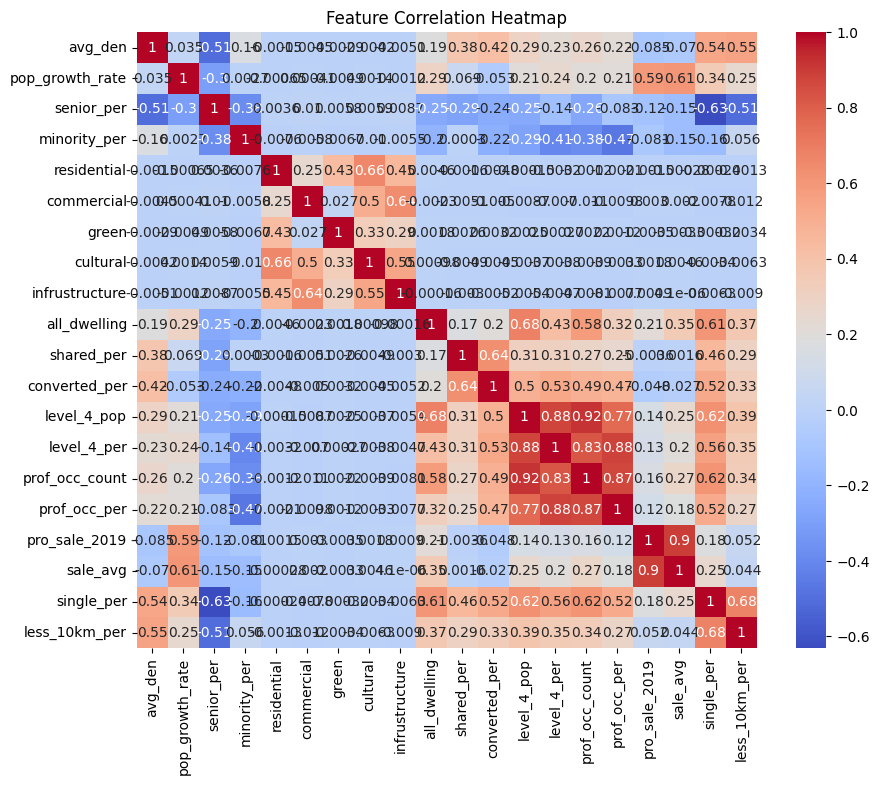

In [71]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(df_sentence[feature_cols_all].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

In [72]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_for_vif = df_sentence[feature_cols_all]
vif_data = pd.DataFrame()
vif_data["feature"] = X_for_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

print(vif_data)

MissingDataError: exog contains inf or nans

In [87]:
feature_cols = ['avg_den', 'pop_growth_rate','senior_per', 
                'minority_per','residential', 'commercial', 
                'green', 'cultural', 'infrustructure','all_dwelling', 
                'converted_per', 'level_4_per', 
                'prof_occ_per', 
                'sale_avg', 'single_per'
]

X = df_sentence[feature_cols]
y = df_sentence['gentrified']  # 0 / 1

# 拆分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.25, random_state=42
)

# 计算样本数
true_count = df_sentence['gentrified'].sum()
false_count = len(df_sentence) - true_count
scale_pos_weight = false_count / true_count


# 模型训练
model = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
model.fit(X_train, y_train)

# 预测 & 评估
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

from sklearn.metrics import roc_auc_score, average_precision_score
y_proba = model.predict_proba(X_test)[:, 1]  # 取预测为 1 的概率
print("AUROC:", roc_auc_score(y_test, y_proba))
print("AUPRC:", average_precision_score(y_test, y_proba))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     34385
           1       1.00      1.00      1.00      4457

    accuracy                           1.00     38842
   macro avg       1.00      1.00      1.00     38842
weighted avg       1.00      1.00      1.00     38842

AUROC: 0.9997828506143838
AUPRC: 0.9995557064957652


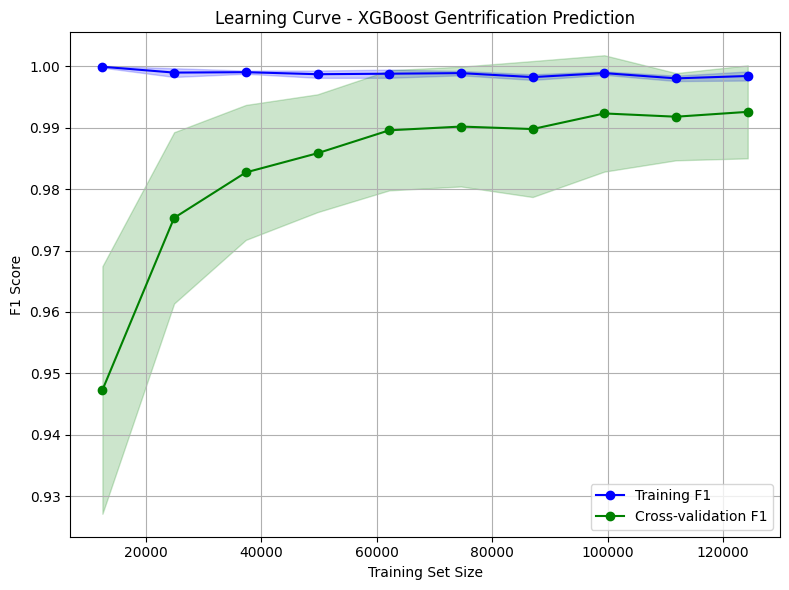

In [86]:
# learning curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    estimator=model,
    X=X,
    y=y,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='f1',
    n_jobs=-1,
    shuffle=True,
    random_state=42
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# 画图
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Training F1')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Cross-validation F1')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.2, color='blue')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.2, color='green')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve - XGBoost Gentrification Prediction')
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()
plt.show()


In [89]:
base_cols = ['avg_den', 'pop_growth_rate','senior_per', 
            'minority_per','all_dwelling', 
            'converted_per', 'level_4_per', 
            'prof_occ_per', 
            'sale_avg', 'single_per']

history_cols = ['minority_per','all_dwelling', 'converted_per', 'level_4_per', 'prof_occ_per', 'single_per']
time_cols = ['avg_den', 'pop_growth_rate','senior_per', 'sale_avg']
text_cols = ['residential', 'commercial', 'green', 'cultural', 'infrustructure']

X_base = df_sentence[text_cols]
y_base = df_sentence['gentrified']  # 0 / 1

# 拆分训练集和测试集
X_base_train, X_base_test, y_base_train, y_base_test = train_test_split(
    X_base, y_base, stratify=y_base, test_size=0.25, random_state=42
)

# 模型训练
model_base = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
model_base.fit(X_base_train, y_base_train)

# 预测 & 评估
y_base_pred = model_base.predict(X_base_test)
print(classification_report(y_base_test, y_base_pred))

y_base_proba = model_base.predict_proba(X_base_test)[:, 1]  # 取预测为 1 的概率
print("AUROC:", roc_auc_score(y_base_test, y_base_proba))
print("AUPRC:", average_precision_score(y_base_test, y_base_proba))

              precision    recall  f1-score   support

           0       0.88      0.52      0.65     34385
           1       0.11      0.47      0.18      4457

    accuracy                           0.51     38842
   macro avg       0.50      0.49      0.42     38842
weighted avg       0.79      0.51      0.60     38842

AUROC: 0.4941588453073753
AUPRC: 0.11290176324743935


In [79]:
X = df_sentence[['residential', 'commercial', 'green', 'cultural', 'infrustructure']]
y = df_sentence['gentrified']

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X, y)

X_resampled_train, X_resampled_test, y_resampled_train, y_resampled_test = train_test_split(X_resampled, y_resampled, 
                                                                                            stratify=y_resampled, 
                                                                                            test_size=0.25, 
                                                                                            random_state=42)

scale_pos_weight = len(y_resampled_train[y_resampled_train == 0]) / len(y_resampled_train[y_resampled_train == 1])

model_resampled = XGBClassifier(scale_pos_weight = scale_pos_weight,
                      random_state=42, 
                      eval_metric="aucpr")

model_resampled.fit(X_resampled_train, y_resampled_train)

# Evaluate
y_resampled_pred = model_resampled.predict(X_resampled_test)
print(classification_report(y_resampled_test, y_resampled_pred))
y_resampled_proba = model_resampled.predict_proba(X_resampled_test)[:, 1]  # 取预测为 1 的概率
print("AUROC:", roc_auc_score(y_resampled_test, y_resampled_proba))
print("AUPRC:", average_precision_score(y_resampled_test, y_resampled_proba))

              precision    recall  f1-score   support

           0       0.50      0.41      0.45      4457
           1       0.50      0.59      0.54      4456

    accuracy                           0.50      8913
   macro avg       0.50      0.50      0.50      8913
weighted avg       0.50      0.50      0.50      8913

AUROC: 0.5027114771954149
AUPRC: 0.5050918170203782


In [80]:
print(f"scale_pos_weight = {scale_pos_weight}")

scale_pos_weight = 0.9999252056843679


<Figure size 1000x600 with 0 Axes>

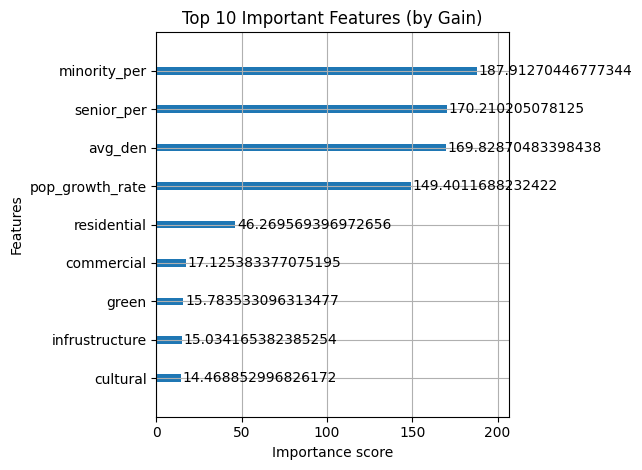

In [136]:
# feature importance
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(model, importance_type='gain', max_num_features=10)
plt.title("Top 10 Important Features (by Gain)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [137]:
X_semantic = df_sentence[['residential', 'commercial', 'green', 'cultural', 'infrustructure']]
y_semantic = df_sentence['gentrified']

# 拆分训练集和测试集
X_semantic_train, X_semantic_test, y_semantic_train, y_semantic_test = train_test_split(
    X_semantic, y_semantic, stratify=y_semantic, test_size=0.2, random_state=42
)

# 计算权重
true_count = df_sentence['gentrified'].sum()
false_count = len(df_sentence) - true_count
scale_pos_weight = false_count / true_count

# 模型训练
model_semantic = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight)
model_semantic.fit(X_semantic_train, y_semantic_train)

# 预测 & 评估
y_semantic_pred = model_semantic.predict(X_semantic_test)
print(classification_report(y_semantic_test, y_semantic_pred))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     29373
           1       0.08      0.45      0.14      1701

    accuracy                           0.70     31074
   macro avg       0.52      0.58      0.48     31074
weighted avg       0.91      0.70      0.78     31074



 99%|===================| 38478/38842 [01:27<00:00]        

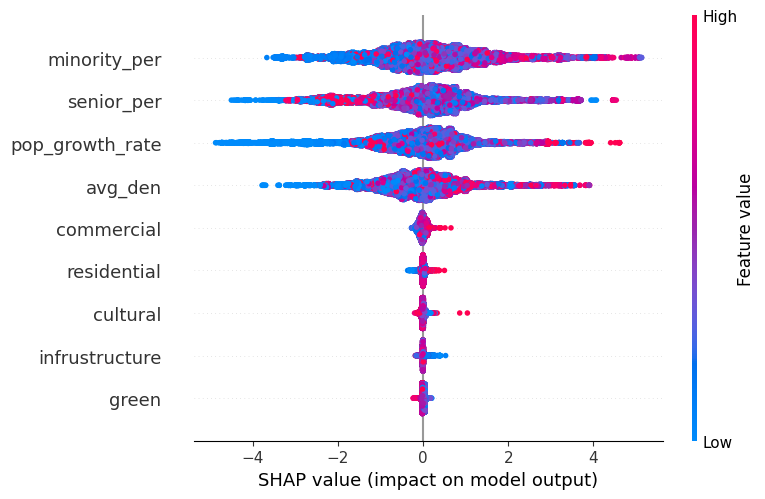

In [138]:
import shap

explainer = shap.Explainer(model, X_train)
# 对测试集进行解释
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)

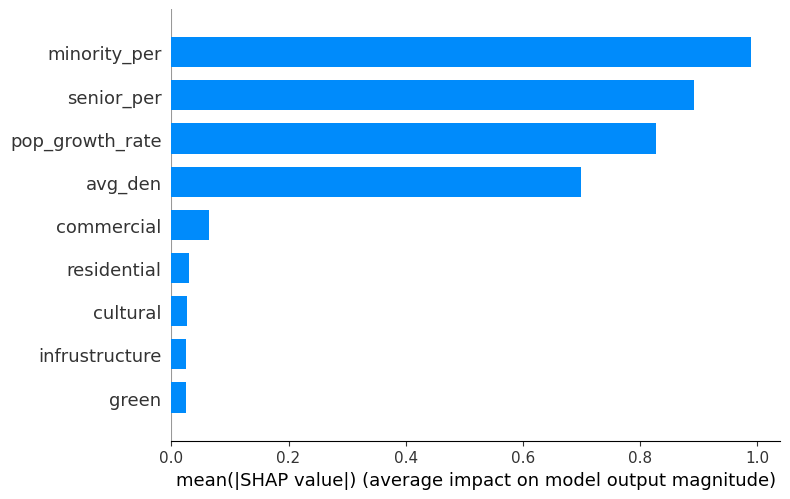

In [139]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

In [140]:
from sklearn.feature_extraction.text import CountVectorizer

texts = df_sentence[df_sentence['gentrified'] == 1]['sentence']
vec = CountVectorizer(ngram_range=(1, 3), stop_words='english', max_features=1000)
X = vec.fit_transform(texts)
counts = pd.DataFrame(X.toarray(), columns=vec.get_feature_names_out())
top_terms = counts.sum().sort_values(ascending=False).head(30)
print(top_terms)

rear                     3563
extension                2739
floor                    2385
storey                   2306
use                      2143
single                   1851
existing                 1824
planning                 1664
roof                     1629
condition                1622
ground                   1600
single storey            1596
permission               1533
planning permission      1478
rear extension           1464
dated                    1448
class                    1353
installation             1276
storey rear              1237
erection                 1197
new                      1189
level                    1155
ground floor             1149
details                  1109
storey rear extension    1098
pursuant                 1093
single storey rear       1086
building                 1037
alterations               992
replacement               968
dtype: int64


In [141]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# 按照 gentrified 分组
text_1 = df_sentence[df_sentence['gentrified'] == 1]['sentence']
text_0 = df_sentence[df_sentence['gentrified'] == 0]['sentence']

# 提取常见 1~3gram 短语
vec = CountVectorizer(ngram_range=(1, 6), stop_words='english', max_features=3000)
X1 = vec.fit_transform(text_1)
X0 = vec.transform(text_0)

# 词频统计
freq_1 = X1.sum(axis=0).A1
freq_0 = X0.sum(axis=0).A1
ngrams = vec.get_feature_names_out()

# 合成 dataframe
freq_df = pd.DataFrame({
    'ngram': ngrams,
    'freq_gentri': freq_1,
    'freq_non_gentri': freq_0
})


In [142]:
# 过滤掉包含超过 50% 数字的 n-gram
import re

def is_mostly_numeric(ngram):
    return sum(c.isdigit() for c in ngram) / len(ngram) > 0.3

freq_df2 = freq_df[~freq_df['ngram'].apply(is_mostly_numeric)]

irrelevant_keywords = ['permission', 'street', 'dated', 'reference', 'february', 'ae']
filtered_df = freq_df2[~freq_df2['ngram'].str.contains('|'.join(irrelevant_keywords), case=False)]

# 避免除零错误，加1平滑
filtered_df['freq_ratio'] = (filtered_df['freq_gentri'] + 1) / (filtered_df['freq_non_gentri'] + 1)
filtered_df['diff'] = filtered_df['freq_gentri'] - filtered_df['freq_non_gentri']
filtered_df = filtered_df.sort_values(by='freq_ratio', ascending=False)

C:\Users\hp\AppData\Local\Temp\ipykernel_29088\774835773.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['freq_ratio'] = (filtered_df['freq_gentri'] + 1) / (filtered_df['freq_non_gentri'] + 1)
C:\Users\hp\AppData\Local\Temp\ipykernel_29088\774835773.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['diff'] = filtered_df['freq_gentri'] - filtered_df['freq_non_gentri']


In [143]:
# 设置条件：gentri 中频率 > 50，且比值 > 2
filtered = filtered_df[(filtered_df['freq_gentri'] > 0) & (filtered_df['freq_ratio'] > 2)]
print(filtered)  # 这就是“绅士化强关联短语”

                                                ngram  freq_gentri  \
2858                                      upper brook           23   
1863                                     north audley           17   
768                                            curzon           17   
406                                            audley           21   
1949                                    park crescent           26   
1370                                        grosvenor           24   
1314  ful demolition existing buildings redevelopment           16   

      freq_non_gentri  freq_ratio  diff  
2858                0   24.000000    23  
1863                0   18.000000    17  
768                 1    9.000000    16  
406                 2    7.333333    19  
1949                4    5.400000    22  
1370                9    2.500000    15  
1314                7    2.125000     9  


In [144]:
# Undersampling

from sklearn.utils import resample

# separate
df_0 = df_sentence[df_sentence['gentrified'] == 0]
df_1 = df_sentence[df_sentence['gentrified'] == 1]

# Random downsampling of class 0
df_0_down = resample(df_0, replace=False, n_samples=len(df_1), random_state=42)

# merge
df_balanced = pd.concat([df_0_down, df_1])

In [145]:
X_bal = df_balanced[['residential', 'commercial', 'green', 'cultural', 'infrustructure']]
y_bal = df_balanced['gentrified']

# 拆分训练集和测试集
X_bal_train, X_bal_test, y_bal_train, y_bal_test = train_test_split(
    X_bal, y_bal, stratify=y_bal, test_size=0.2, random_state=42
)

# 模型训练
model_balanced = XGBClassifier(random_state=42)
model_balanced.fit(X_bal_train, y_bal_train)

# 预测 & 评估
y_bal_pred = model_balanced.predict(X_bal_test)
print(classification_report(y_bal_test, y_bal_pred))

              precision    recall  f1-score   support

           0       0.57      0.57      0.57      1701
           1       0.57      0.57      0.57      1701

    accuracy                           0.57      3402
   macro avg       0.57      0.57      0.57      3402
weighted avg       0.57      0.57      0.57      3402



<Figure size 1000x600 with 0 Axes>

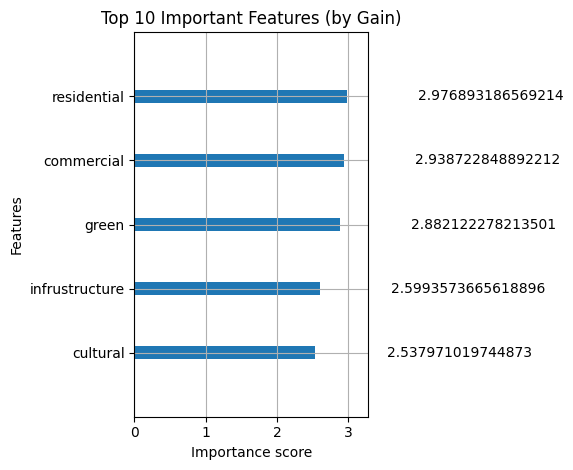

In [146]:
# feature importance
from xgboost import plot_importance

plt.figure(figsize=(10, 6))
plot_importance(model_balanced, importance_type='gain', max_num_features=10)
plt.title("Top 10 Important Features (by Gain)")
plt.grid(True)
plt.tight_layout()
plt.show()

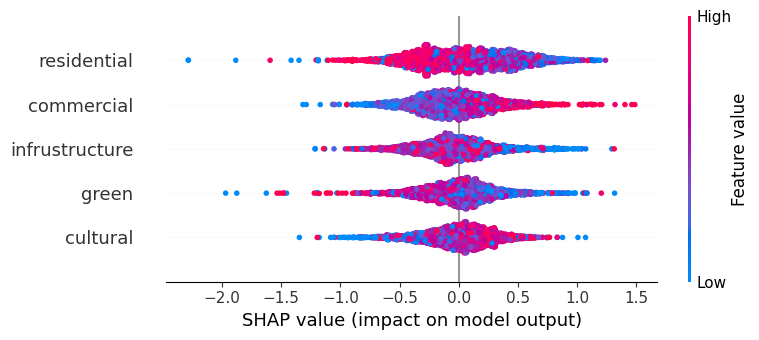

In [147]:
explainer_balanced = shap.Explainer(model_balanced, X_bal_train)
# 对测试集进行解释
shap_values_bal = explainer_balanced(X_bal_test)
shap.summary_plot(shap_values_bal, X_bal_test)


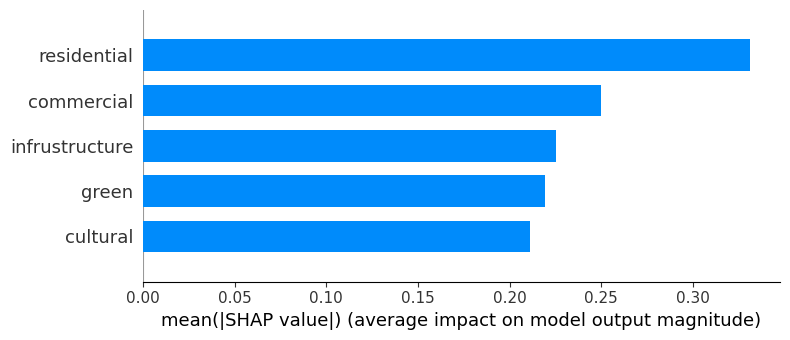

In [148]:
shap.summary_plot(shap_values_bal, X_bal_test, plot_type="bar")

In [149]:
df_sentence['high_price'] = df_sentence['high_price'].astype(int)

X_high_price = df_sentence[feature_cols]
y_high_price = df_sentence['high_price']  # 0 / 1

# 拆分训练集和测试集
X_high_price_train, X_high_price_test, y_high_price_train, y_high_price_test = train_test_split(
    X_high_price, y_high_price, stratify=y_high_price, test_size=0.2, random_state=42
)

# # 计算权重
# true_count = df_sentence['high_price'].sum()
# false_count = len(df_sentence) - true_count
# scale_pos_weight = false_count / true_count

# 模型训练
model_high_price = XGBClassifier(random_state=42)
model_high_price.fit(X_high_price_train, y_high_price_train)

# 预测 & 评估
y_high_price_pred = model_high_price.predict(X_high_price_test)
print(classification_report(y_high_price_test, y_high_price_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18734
           1       0.98      0.96      0.97     12340

    accuracy                           0.98     31074
   macro avg       0.98      0.97      0.98     31074
weighted avg       0.98      0.98      0.98     31074



In [150]:
df_sentence['high_price'] = df_sentence['high_price'].astype(int)

X_high_base = df_sentence[base_cols]
y_high_base = df_sentence['high_price']  # 0 / 1

# 拆分训练集和测试集
X_high_base_train, X_high_base_test, y_high_base_train, y_high_base_test = train_test_split(
    X_high_base, y_high_base, stratify=y_high_base, test_size=0.2, random_state=42
)

# # 计算权重
# true_count = df_sentence['high_price'].sum()
# false_count = len(df_sentence) - true_count
# scale_pos_weight = false_count / true_count

# 模型训练
model_high_base = XGBClassifier(random_state=42)
model_high_base.fit(X_high_base_train, y_high_base_train)

# 预测 & 评估
y_high_base_pred = model_high_base.predict(X_high_base_test)
print(classification_report(y_high_base_test, y_high_base_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     18734
           1       0.98      0.96      0.97     12340

    accuracy                           0.98     31074
   macro avg       0.98      0.98      0.98     31074
weighted avg       0.98      0.98      0.98     31074



In [151]:
print(df_sentence.columns)

Index(['gentrified', 'centroid', 'geometry', 'high_price', 'price_grow',
       'sentence_id', 'pop_growth_rate', 'avg_den', 'senior_per',
       'minority_per', 'residential', 'commercial', 'green', 'cultural',
       'infrustructure', 'sentence'],
      dtype='object')


In [152]:
X_house_price = df_sentence[feature_cols]
y_house_price = df_sentence['price_grow'] 

# 拆分训练集和测试集
X_house_price_train, X_house_price_test, y_house_price_train, y_house_price_test = train_test_split(
    X_house_price, y_house_price, test_size=0.2, random_state=42
)

from xgboost import XGBRegressor

# 模型训练
model_house_price = XGBRegressor(random_state=42)
model_house_price.fit(X_house_price_train, y_house_price_train)

# 预测 & 评估
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_house_price_pred = model_house_price.predict(X_house_price_test)

print("MAE:", mean_absolute_error(y_house_price_test, y_house_price_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_house_price_test, y_house_price_pred)))
print("R²:", r2_score(y_house_price_test, y_house_price_pred))


MAE: 0.0529565654177904
RMSE: 0.08101518566252612
R²: 0.9064018530256089


In [153]:
X_house_price_base = df_sentence[base_cols]
y_house_price_base = df_sentence['price_grow'] 

# 拆分训练集和测试集
X_house_price_base_train, X_house_price_base_test, y_house_price_base_train, y_house_price_base_test = train_test_split(
    X_house_price_base, y_house_price_base, test_size=0.2, random_state=42
)

from xgboost import XGBRegressor

# 模型训练
model_house_price_base = XGBRegressor(random_state=42)
model_house_price_base.fit(X_house_price_base_train, y_house_price_base_train)

# 预测 & 评估
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_house_price_base_pred = model_house_price_base.predict(X_house_price_base_test)

print("MAE:", mean_absolute_error(y_house_price_base_test, y_house_price_base_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_house_price_base_test, y_house_price_base_pred)))
print("R²:", r2_score(y_house_price_base_test, y_house_price_base_pred))

MAE: 0.04910461512469831
RMSE: 0.07535321723919937
R²: 0.9190274182842302


In [154]:
# 标注化

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cols_needed = df_sentence[feature_cols_all]
cols_scaled_array = scaler.fit_transform(cols_needed)
cols_scaled = pd.DataFrame(cols_scaled_array, columns=feature_cols_all, index=df_sentence.index)

In [155]:
print(cols_scaled)

         avg_den  pop_growth_rate  senior_per  minority_per  residential  \
0       1.140736         0.155757   -0.749555     -0.983774     0.071234   
1       0.532369        -0.353406   -0.576095     -0.233055     0.921787   
2       0.738642         0.012816    0.510843     -0.509796     0.079975   
3      -1.319139        -0.512048   -0.221020      2.162211    -1.369991   
4       0.326474         2.088957   -0.868025      1.741920    -0.740964   
...          ...              ...         ...           ...          ...   
155362  1.078781        -0.096944   -0.478327      1.609866    -2.039838   
155363  1.220407         0.011299   -0.713521     -0.647501     0.634130   
155364  2.376771        -0.123245   -0.876785      2.178409     1.035743   
155365  0.652822         0.173300   -0.784743     -0.080064    -1.588283   
155366  1.518030         0.121065   -1.197164      1.597462    -1.232107   

        commercial     green  cultural  infrustructure  
0        -0.938356 -1.255665 -

In [156]:
X_scaled = cols_scaled
y_scaled = df_sentence['gentrified']  # 0 / 1

# 拆分训练集和测试集
X_scaled_train, X_scaled_test, y_scaled_train, y_scaled_test = train_test_split(
    X_scaled, y_scaled, stratify=y_scaled, test_size=0.2, random_state=42
)

# # 计算权重
# true_count = df_sentence['high_price'].sum()
# false_count = len(df_sentence) - true_count
# scale_pos_weight = false_count / true_count

# 模型训练
model_scaled = XGBClassifier(random_state=42, scale_pos_weight = scale_pos_weight)
model_scaled.fit(X_scaled_train, y_scaled_train)

# 预测 & 评估
y_scaled_pred = model_scaled.predict(X_scaled_test)
print(classification_report(y_scaled_test, y_scaled_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29373
           1       0.97      0.99      0.98      1701

    accuracy                           1.00     31074
   macro avg       0.98      1.00      0.99     31074
weighted avg       1.00      1.00      1.00     31074



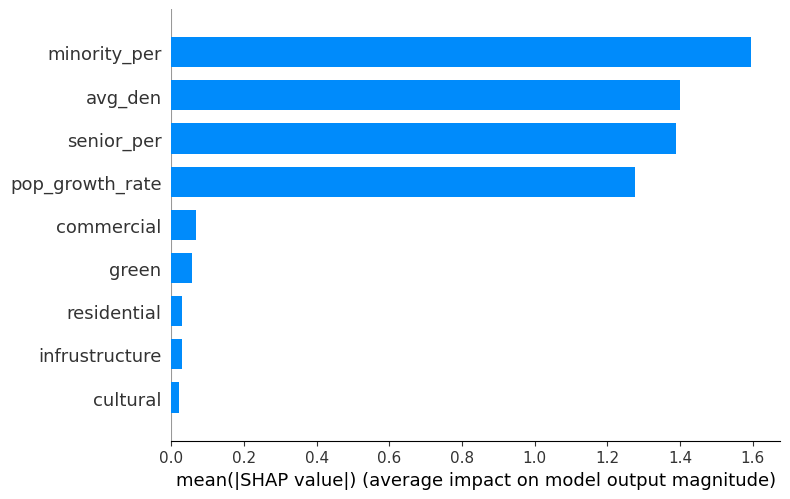

In [157]:
# 1. 创建 explainer（适用于 XGBoost）
explainer_scaled = shap.TreeExplainer(model_scaled)  # 你训练好的模型

# 2. 计算 SHAP 值（建议用测试集或样本子集）
shap_values_scaled = explainer_scaled.shap_values(X_scaled_test)

# 3. 可视化 summary plot（整体特征影响力）
shap.summary_plot(shap_values_scaled, X_scaled_test, plot_type="bar")

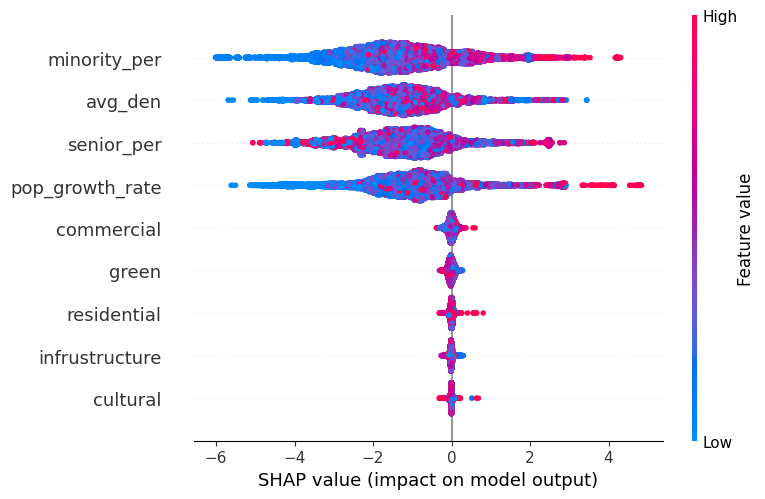

In [158]:
shap.summary_plot(shap_values_scaled, X_scaled_test)

In [159]:
# 只关注gentrified = 1的地区
X_scaled_pos = X_scaled_test[y_scaled_test == 1]

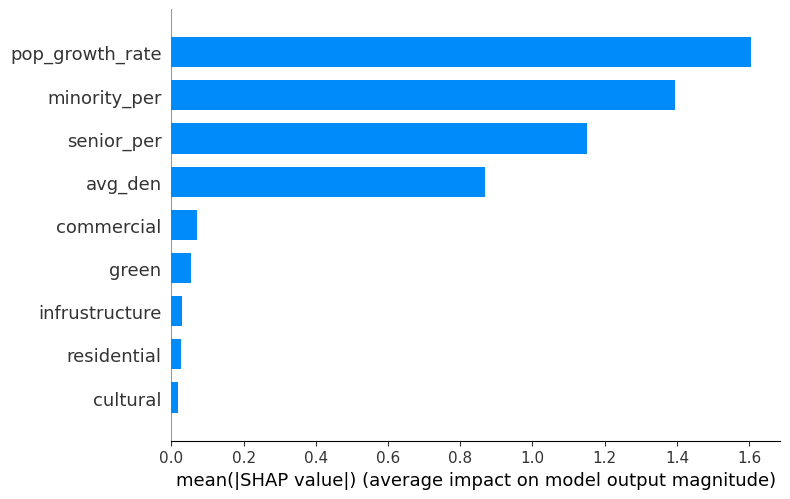

In [160]:
explainer_scaled_pos = shap.TreeExplainer(model_scaled) 

shap_values_scaled_pos = explainer_scaled_pos.shap_values(X_scaled_pos)

shap.summary_plot(shap_values_scaled_pos, X_scaled_pos, plot_type="bar")

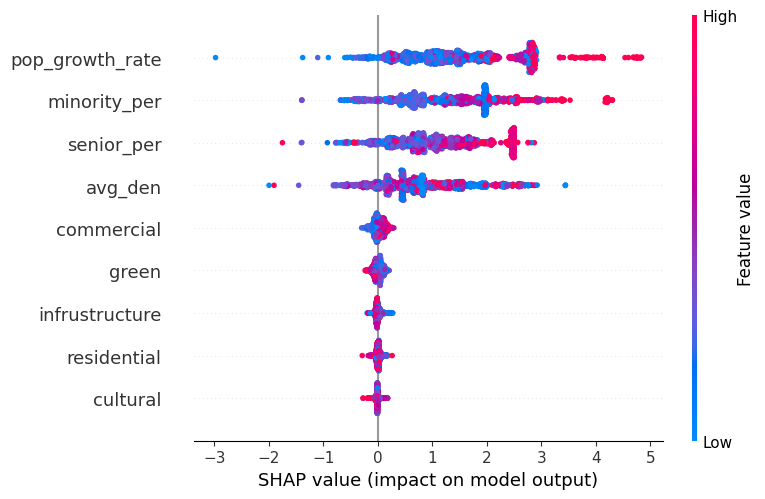

In [161]:
shap.summary_plot(shap_values_scaled_pos, X_scaled_pos)

In [162]:
shap.force_plot(explainer_scaled_pos.expected_value, shap_values_scaled_pos[100], X_scaled_pos.iloc[100])

# Update anchor

In [37]:
from bertopic import BERTopic

# 提取文本（只选 gentrified = 1 的样本）
texts = df_sentence[df_sentence['gentrified'] == 1]['sentence'].tolist()

# 构建 BERTopic 模型
topic_model = BERTopic()
topics, probs = topic_model.fit_transform(texts)

# 可视化
topic_model.visualize_topics()
topic_model.get_topic_info()

KeyboardInterrupt: 

In [164]:
# 自动合并小主题，比如最终保留 10 个主题
topic_model.reduce_topics(texts, nr_topics=10)
# 可视化
topic_model.visualize_topics()
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,2175,-1_of_to_and_the,"[of, to, and, the, floor, rear, use, condition...",[Single storey side and rear extension to acco...
1,0,3540,0_rear_extension_of_and,"[rear, extension, of, and, storey, single, the...","[Erection of roof extension, ground floor sing..."
2,1,1843,1_of_to_planning_and,"[of, to, planning, and, use, permission, condi...",[Approval of details pursuant to condition 20 ...
3,2,398,2_illuminated_measuring_display_sign,"[illuminated, measuring, display, sign, intern...",[Display of 2 x internally illuminated fascia ...
4,3,269,3_crown_reduce_by_t1,"[crown, reduce, by, t1, points, reduction, syc...","[1 x lime (T2): crown reduce to previous, most..."
5,4,136,4_installation_antennas_kiosk_telephone,"[installation, antennas, kiosk, telephone, equ...","[Installation of new and replacement antennas,..."
6,5,53,5_no_1no_installation_3no,"[no, 1no, installation, 3no, 2no, of, removal,...","[Installation of 1 no., Installation of 1 no.,..."
7,6,37,6_see_application_pre_form,"[see, application, pre, form, advice, preappli...","[See Application Form, See application form, S..."
8,7,32,7_formation_vehicular_crossover_access,"[formation, vehicular, crossover, access, kerb...",[Formation of vehicular crossover at the front...
9,8,20,8_applicants_ref_oak_cedar,"[applicants, ref, oak, cedar, yew, maple, appl...","[1 x Oak (applicant's ref., 1 x Oak (applicant..."


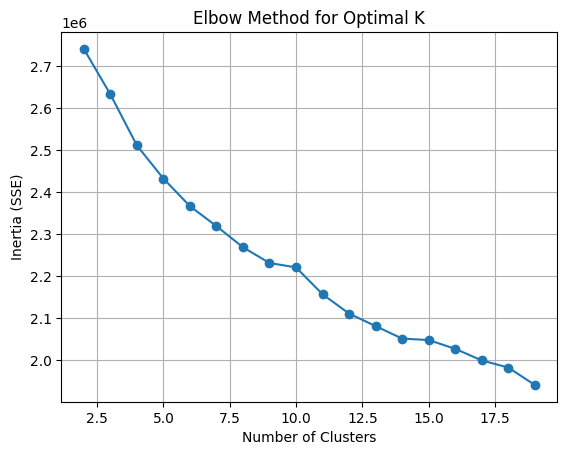

In [39]:
# 试试kmean 聚类

from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

joined_cleaned['gentrified'] = joined_cleaned['gentrified'].astype(int)

# Step 1: 取出 SBERT 向量列（你有384维）
sbert_cols = [col for col in joined_cleaned.columns if col.startswith('sbert_')]
X_embed = joined_cleaned[sbert_cols]

inertias = []
cluster_range = range(2, 20)  # 一般选 2~15

for k in cluster_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_embed)
    inertias.append(km.inertia_)

plt.plot(cluster_range, inertias, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia (SSE)")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

In [42]:
# Step 2: 聚类， 根据之前的结果可以选6或11
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
joined_cleaned['text_cluster'] = kmeans.fit_predict(X_embed)

# Step 3: One-hot 编码这些 cluster（也可以直接用 cluster label）
onehot = pd.get_dummies(joined_cleaned['text_cluster'], prefix='anchor_cluster')

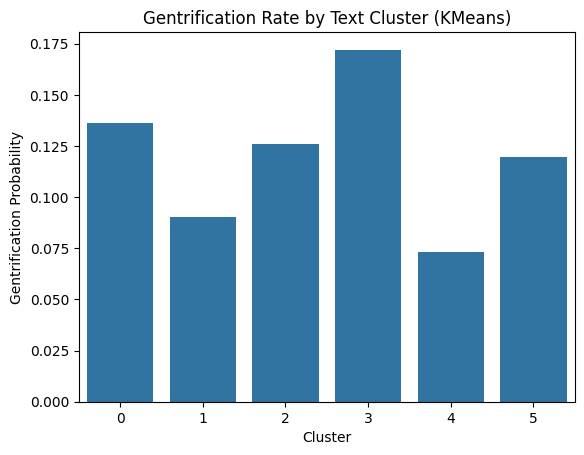

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# 查看各个聚类中 gentrified 的比例
cluster_gent_rate = joined_cleaned.groupby('text_cluster')['gentrified'].mean()
sns.barplot(x=cluster_gent_rate.index, y=cluster_gent_rate.values)
plt.title("Gentrification Rate by Text Cluster (KMeans)")
plt.xlabel("Cluster")
plt.ylabel("Gentrification Probability")
plt.show()

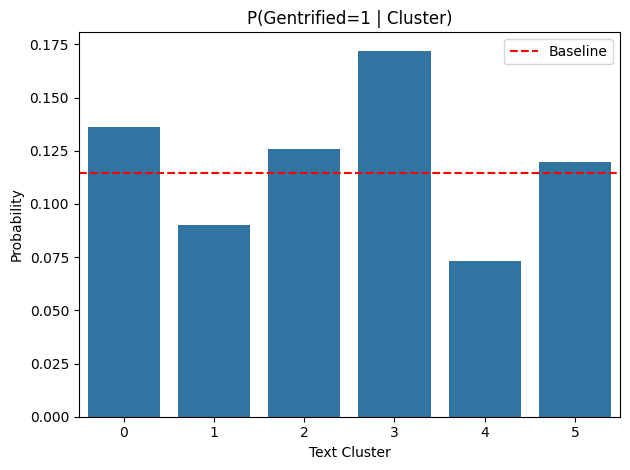

In [44]:
cluster_g = joined_cleaned.groupby('text_cluster')['gentrified'].mean().sort_values()

sns.barplot(x=cluster_g.index, y=cluster_g.values)
plt.title("P(Gentrified=1 | Cluster)")
plt.ylabel("Probability")
plt.xlabel("Text Cluster")
plt.axhline(y=joined_cleaned['gentrified'].mean(), color='red', linestyle='--', label='Baseline')
plt.legend()
plt.tight_layout()
plt.show()

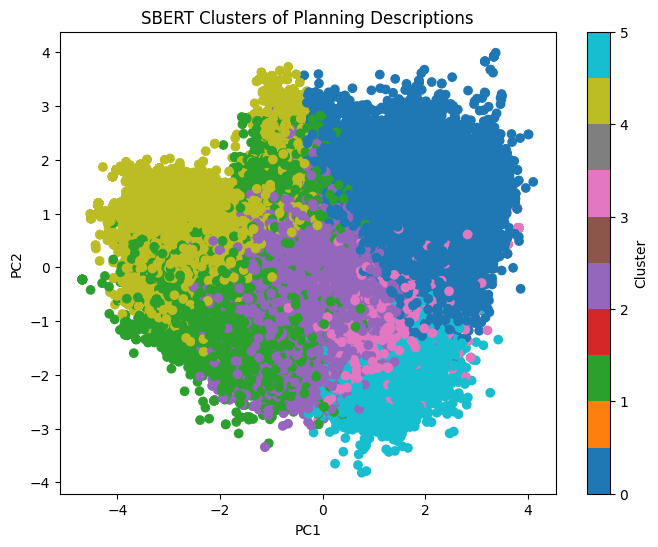

In [45]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 降维可视化聚类分布
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X_embed)
plt.figure(figsize=(8,6))
plt.scatter(X_2d[:,0], X_2d[:,1], c=joined_cleaned['text_cluster'], cmap='tab10')
plt.title("SBERT Clusters of Planning Descriptions")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Cluster')
plt.show()


In [172]:
for c in range(n_clusters):
    print(f"\n Cluster {c}:")
    sample_texts = joined_cleaned[joined_cleaned['text_cluster'] == c]['description'].sample(5, random_state=42)
    for t in sample_texts:
        print(f"- {t}")


 Cluster 0:
- Certificate of lawfulness: existing use of property as C4 - HMO
- Details required by Condition 7 (Professional Management of Proposed Engineering Works) attached to planning permission ref. PP/19/02857 dated 14th June 2019 (Excavation of single storey basement beneath building footprint and part of garden; amendment to front light well; demolition of garage at rear and replacement with garden area; physical alterations to elevations and fenestration).
- Non material amendment to allow the extension of the decking approved under planning permission 00064/15/P1 dated 07/05/2014 for the erection of a single storey rear extension and a rear roof extension
- Submission of details of conditions 6 ( temporary tree protection), 7 ( details of excavations of drainage), 22 ( tree felling/pruning specification) and 23 ( tree protection plan) pursuant to planning permission F/03607/14 (31/10/2014)
- changes to planning permissions recently granted.

 Cluster 1:
- Alteration of roof

In [173]:
from sklearn.feature_extraction.text import CountVectorizer


texts = joined_cleaned[joined_cleaned['text_cluster'] == 2]['description']
vec = CountVectorizer(stop_words='english', ngram_range=(1,2), max_features=10)
X = vec.fit_transform(texts)
top_words = vec.get_feature_names_out()
print(f"\n Cluster {2} Top Words:")
print(top_words)


 Cluster 2 Top Words:
['erection' 'existing' 'extension' 'floor' 'ground' 'new' 'rear' 'single'
 'storey' 'use']


In [177]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

# 🔹 假设你有一列 'text_cluster' 是聚类标签，'description' 是原始文本
# 🔹 提取 cluster 2 和 cluster 3 的文本（修改成你自己的列名）
cluster_target = joined_cleaned[joined_cleaned['text_cluster'].isin([0, 2, 3])]['description'].dropna()

# 🔹 设定 n-gram 范围，例如 bi-gram 到 4-gram
vectorizer = CountVectorizer(ngram_range=(2, 8), stop_words='english', min_df=5)  # min_df=5 是为了避免太稀疏

X = vectorizer.fit_transform(cluster_target)

# 🔹 获取短语和频次
phrase_freq = pd.DataFrame({
    'phrase': vectorizer.get_feature_names_out(),
    'count': X.sum(axis=0).A1
}).sort_values(by='count', ascending=False)

# 🔹 显示前20个高频短语
print(phrase_freq.head(20))

                              phrase  count
194674           planning permission  21887
143551                  ground floor  15901
239034                 single storey  14020
211005                rear extension  10300
265891                     use class  10172
100100           demolition existing   9609
207346            pursuant condition   9555
252422                   storey rear   8429
72888                     change use   8286
132803                   floor level   7306
190904                permission ref   6804
252459         storey rear extension   6786
235214                self contained   6774
239815            single storey rear   6709
104146              details pursuant   6643
197074       planning permission ref   6623
239837  single storey rear extension   5447
256566            submission details   4696
224430             residential units   4678
104150    details pursuant condition   4595


In [193]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 假设你有下面两个列：
# final_df['cluster']：聚类结果
# final_df['text']：原始申请语句

# 针对每个簇单独跑 tf-idf
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(joined_cleaned['description'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

# 将聚类标签加入
tfidf_df['text_cluster'] = joined_cleaned['text_cluster'].values

# 取出 cluster 0 的 top 词
cluster_0_mean = tfidf_df[tfidf_df['text_cluster'] == 0].drop('text_cluster', axis=1).mean().sort_values(ascending=False)
print("Top words for Cluster 0:")
print(cluster_0_mean.head(20))


Top words for Cluster 0:
condition      0.078250
planning       0.077575
permission     0.069487
use            0.067740
details        0.067622
dated          0.062013
pursuant       0.058992
class          0.043336
ref            0.041164
application    0.040408
ful            0.033319
submission     0.032382
18             0.030230
approval       0.028571
building       0.027797
change         0.027589
certificate    0.027262
existing       0.027153
17             0.024487
residential    0.023948
dtype: float64


In [196]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 针对某一 cluster 的文本
texts_cluster_2 = joined_cleaned[joined_cleaned['text_cluster'] == 3]['description']

# 文本转词袋
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_cluster = vectorizer.fit_transform(texts_cluster_2)

# LDA 主题建模
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(X_cluster)

# 展示关键词
words = vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic #{topic_idx + 1}:")
    print([words[i] for i in topic.argsort()[:-11:-1]])


Topic #1:
['illuminated', 'sign', 'internally', 'display', 'fascia', 'measuring', 'non', 'signs', 'projecting', 'installation']
Topic #2:
['installation', 'existing', 'replacement', 'new', 'antennas', 'equipment', 'removal', 'kiosk', 'digital', 'ancillary']
Topic #3:
['application', 'installation', 'form', 'street', 'temporary', 'atm', 'use', '2019', 'public', 'pre']


In [206]:
import re

def clean_text(text):
    text = text.lower()  # 降为小写
    text = re.sub(r'[^\w\s]', ' ', text)  # 删除所有标点符号（替换为空格）
    text = re.sub(r'\b(please|see|attached|application|form|number|app|visit|consent|pre|for|is)\b', '', text)
    text = re.sub(r'\s+', ' ', text)  # 多个空格变一个
    return text.strip()


joined_cleaned['clean_text'] = joined_cleaned['description'].apply(clean_text)

In [207]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from hdbscan import HDBSCAN

texts = joined_cleaned[joined_cleaned['text_cluster'] == 2]['clean_text'].tolist()
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')

# 手动构造 HDBSCAN 模型，限制线程
hdbscan_model = HDBSCAN(min_cluster_size=10, core_dist_n_jobs=1)

topic_model = BERTopic(
    embedding_model=embedding_model,
    hdbscan_model=hdbscan_model,
    verbose=True
)

topics, probs = topic_model.fit_transform(texts_cluster_2)

topic_model.get_topic_info()
topic_model.get_topic(0)
topic_model.visualize_barchart()


2025-08-05 13:38:51,050 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/300 [00:00<?, ?it/s]

2025-08-05 13:39:19,853 - BERTopic - Embedding - Completed ✓
2025-08-05 13:39:19,853 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-05 13:39:24,011 - BERTopic - Dimensionality - Completed ✓
2025-08-05 13:39:24,011 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-05 13:39:24,219 - BERTopic - Cluster - Completed ✓
2025-08-05 13:39:24,224 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-05 13:39:24,421 - BERTopic - Representation - Completed ✓


In [46]:
topic_model.get_representative_docs()

ValueError: This BERTopic instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [47]:
import joblib

# 保存模型
joblib.dump(kmeans, "kmean_model_original.pkl")

['kmean_model_original.pkl']

Use the result of cluster to update the anchor we have.

In [179]:
anchor_dict_updated = {
    "residential": ["flat conversion", "refurbishment", "rear extension", "self contained", "single storey", "storey rear extension"],
    "commercial": ["coffee shop", "illuminated sign", "retail unit upgrade", "change use"],
    "green": ["park improvement", "landscaping", "tree planting"],
    "cultural": ["artist studios", "cultural space", "gallery conversion"],
    "infrustructure": ["station upgrade", "utilities improvement", "internally illuminated", "ground floor level"]
}

# 正确计算平均向量：
anchor_vecs_updated = {
    k: np.mean(sbert_model.encode(v), axis=0) for k, v in anchor_dict_updated.items()
}

In [180]:
diverse_results_updated = extract_diverse_anchor_sentences(
    anchor_vecs=anchor_vecs_updated,            # original anchor text
    all_sentences=all_sentences,
    sbert_model=sbert_model,            # SBERT
    topk=50,                            # only comsider the most 50 similar sentences
    anchor_threshold=0.55,              # silimarity with anchor
    sim_threshold=0.70                  # similarity between sentences
)

emcoding all sentences...


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

🔍 extract sentences from each category:  20%|██        | 1/5 [00:00<00:01,  3.35it/s]

✅ residential: select 1 sentences


🔍 extract sentences from each category:  40%|████      | 2/5 [00:00<00:00,  3.69it/s]

✅ commercial: select 3 sentences


🔍 extract sentences from each category:  60%|██████    | 3/5 [00:00<00:00,  3.60it/s]

✅ green: select 5 sentences


🔍 extract sentences from each category:  80%|████████  | 4/5 [00:01<00:00,  3.84it/s]

✅ cultural: select 5 sentences


🔍 extract sentences from each category: 100%|██████████| 5/5 [00:01<00:00,  3.73it/s]

✅ infrustructure: select 11 sentences


In [181]:
for i, item in enumerate(diverse_results_updated["infrustructure"]):
    print(f"{i+1}. {item['sentence']}  (similarity: {item['score']:.2f})")

1. Installation of external lighting and associated infrastructure at ground and first floor level.  (similarity: 0.66)
2. Internal alterations to ground floor layout and rooflights replacement.  (similarity: 0.66)
3. Internal refurbishment of ground floor.  (similarity: 0.64)
4. Installation of railings at ground floor and basement levels to improve light to basement flats.  (similarity: 0.62)
5. Extension of lower ground floor and refurbishment including addition of double glazed metal frame lantern light to lower ground floor extension.  (similarity: 0.61)
6. Internal and external alterations comprising replacement of existing single storey rear projection, alterations to existing kitchen, w.c. and shower room, installation of new boiler and radiators, electric system, new floor finishes to ground and lower ground floor reinstatement of fire place to lower ground floor reception room and enlargement of existing opening at lower ground floor level.  (similarity: 0.60)
7. Internal wor

In [182]:
keyline_vecs_updated = get_anchor_vecs_from_diverse_results(diverse_results_updated, sbert_model)

In [183]:
# 调用函数
score_df_updated = score_sentences_against_anchors(
    anchor_vecs=keyline_vecs_updated,
    all_sentences=all_sentences,
    sbert_model=sbert_model
)

encoding all sentences...


Batches:   0%|          | 0/4856 [00:00<?, ?it/s]

In [184]:
score_df_updated['sentence_id'] = df_label_sentences['sentence_id'].values

In [185]:
df_label_sentences_updated = df_label_sentences[columns_to_keep]
df_label_sentences_updated = df_label_sentences_updated.rename(columns={'sentences': 'sentence'})
df_sentence_updated = df_label_sentences_updated.merge(score_df, on='sentence_id', how='left')

In [186]:
# 计算样本数
true_count = df_sentence_updated['gentrified'].sum()
false_count = len(df_sentence_updated) - true_count
scale_pos_weight_updated = false_count / true_count
print(scale_pos_weight_updated)

17.272021639421382


In [187]:
df_sentence_updated['gentrified'] = df_sentence_updated['gentrified'].astype(int)

cols1 = ['pop_growth_rate', 'avg_den', 'senior_per','minority_per', 
            'residential', 'commercial', 'infrustructure']

X_updated = df_sentence_updated[base_cols]
y_updated = df_sentence_updated['gentrified']  # 0 / 1

# 拆分训练集和测试集
X_updated_train, X_updated_test, y_updated_train, y_updated_test = train_test_split(
    X_updated, y_updated, stratify=y_updated, test_size=0.2, random_state=42
)

# 模型训练
model_updated = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight_updated)
model_updated.fit(X_updated_train, y_updated_train)

# 预测 & 评估
y_updated_pred = model_updated.predict(X_updated_test)
print(classification_report(y_updated_test, y_updated_pred))
y_updated_proba = model_updated.predict_proba(X_updated_test)[:, 1]  # 取预测为 1 的概率
print("AUROC:", roc_auc_score(y_updated_test, y_updated_proba))
print("AUPRC:", average_precision_score(y_updated_test, y_updated_proba))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     29373
           1       0.96      1.00      0.98      1701

    accuracy                           1.00     31074
   macro avg       0.98      1.00      0.99     31074
weighted avg       1.00      1.00      1.00     31074

AUROC: 0.9989853587639914
AUPRC: 0.997500325829127


In [188]:
X_updated_sem = df_sentence_updated[['residential', 'commercial', 'green', 'cultural', 'infrustructure']]
y_updated_sem = df_sentence_updated['gentrified']  # 0 / 1

# 拆分训练集和测试集
X_updated_sem_train, X_updated_sem_test, y_updated_sem_train, y_updated_sem_test = train_test_split(
    X_updated_sem, y_updated_sem, stratify=y_updated_sem, test_size=0.2, random_state=42
)

# 模型训练
model_updated_sem = XGBClassifier(random_state=42, scale_pos_weight=scale_pos_weight_updated)
model_updated_sem.fit(X_updated_sem_train, y_updated_sem_train)

# 预测 & 评估
y_updated_sem_pred = model_updated_sem.predict(X_updated_sem_test)
print(classification_report(y_updated_sem_test, y_updated_sem_pred))

              precision    recall  f1-score   support

           0       0.96      0.71      0.82     29373
           1       0.08      0.45      0.14      1701

    accuracy                           0.70     31074
   macro avg       0.52      0.58      0.48     31074
weighted avg       0.91      0.70      0.78     31074



In [189]:
# Undersampling
# separate
df_0 = df_sentence_updated[df_sentence_updated['gentrified'] == 0]
df_1 = df_sentence_updated[df_sentence_updated['gentrified'] == 1]

# Random downsampling of class 0
df_0_down = resample(df_0, replace=False, n_samples=len(df_1), random_state=42)

# merge
df_balanced_updated = pd.concat([df_0_down, df_1])

In [190]:
X_updated_bal = df_balanced_updated[['avg_den', 'pop_growth_rate', 'residential', 'commercial', 'green', 'cultural', 'infrustructure']]
y_updated_bal = df_balanced_updated['gentrified']  # 0 / 1

# 拆分训练集和测试集
X_updated_bal_train, X_updated_bal_test, y_updated_bal_train, y_updated_bal_test = train_test_split(
    X_updated_bal, y_updated_bal, stratify=y_updated_bal, test_size=0.2, random_state=42
)

# 模型训练
model_updated_bal = XGBClassifier(random_state=42)
model_updated_bal.fit(X_updated_bal_train, y_updated_bal_train)

# 预测 & 评估
y_updated_bal_pred = model_updated_bal.predict(X_updated_bal_test)
print(classification_report(y_updated_bal_test, y_updated_bal_pred))

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1701
           1       0.96      0.97      0.96      1701

    accuracy                           0.96      3402
   macro avg       0.96      0.96      0.96      3402
weighted avg       0.96      0.96      0.96      3402



<Figure size 1000x600 with 0 Axes>

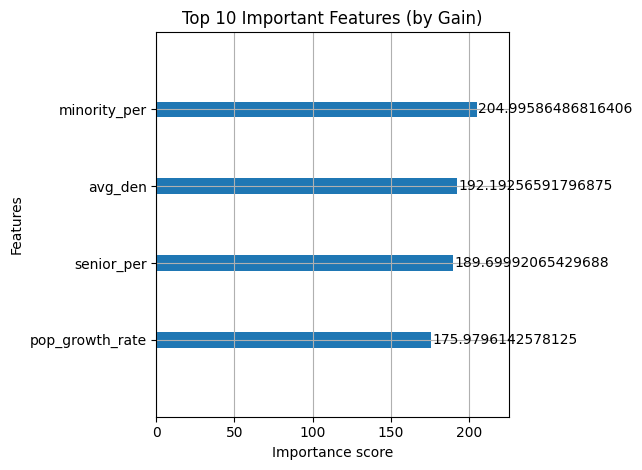

In [191]:
plt.figure(figsize=(10, 6))
plot_importance(model_updated, importance_type='gain', max_num_features=10)
plt.title("Top 10 Important Features (by Gain)")
plt.grid(True)
plt.tight_layout()
plt.show()